In [1]:
#!pip -q install /pstore/home/shetabs1/code/iflai/

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import skorch
import torch
from skorch import NeuralNetClassifier
from tqdm import tqdm
from torchvision import transforms
import torch.nn as nn
from scipy.stats import entropy
import random
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import FeatureAgglomeration

In [3]:
from scifAI.dl.utils import train_validation_test_split
from scifAI.dl.dataset import DatasetGenerator
from scifAI.dl.utils import get_statistics

In [4]:
from scifAI.dl.models import PretrainedModel
from skorch.callbacks import LRScheduler,Checkpoint,EpochScoring,EarlyStopping
import torch.optim as optim
from skorch.helper import predefined_split

In [5]:
from sklearn.random_projection import GaussianRandomProjection

In [6]:
from sklearn.metrics import plot_confusion_matrix, matthews_corrcoef, classification_report,confusion_matrix, accuracy_score, balanced_accuracy_score, cohen_kappa_score, f1_score,  precision_score, recall_score
from statsmodels.stats.contingency_tables import mcnemar
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay


def classification_complete_report(y_true, y_pred ,labels = None  ): 
    print(classification_report(y_true, y_pred, labels = labels))
    print(15*"----")
    print("matthews correlation coeff: %.4f" % (matthews_corrcoef(y_true, y_pred)) )
    print("Cohen Kappa score: %.4f" % (cohen_kappa_score(y_true, y_pred)) )
    print("Accuracy: %.4f & balanced Accuracy: %.4f" % (accuracy_score(y_true, y_pred), balanced_accuracy_score(y_true, y_pred)) )
    print("macro F1 score: %.4f & micro F1 score: %.4f" % (f1_score(y_true, y_pred, average = "macro"), f1_score(y_true, y_pred, average = "micro")) )
    print("macro Precision score: %.4f & micro Precision score: %.4f" % (precision_score(y_true, y_pred, average = "macro"), precision_score(y_true, y_pred, average = "micro")) )
    print("macro Recall score: %.4f & micro Recall score: %.4f" % (recall_score(y_true, y_pred, average = "macro"), recall_score(y_true, y_pred, average = "micro")) )
    cm = confusion_matrix(y_true, y_pred,labels= labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()
    print(15*"----")

In [7]:
metadata = pd.read_csv("/pstore/data/DS4/synapse_data_features/metadata_subset.csv.gz")
metadata

/pstore/apps/Python/3.8.3-2020.07/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,file,experiment,donor,condition,object_number,set,label
0,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,5156,unlabeled,-1
1,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,32020,unlabeled,-1
2,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,55974,unlabeled,-1
3,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,15150,unlabeled,-1
4,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,44814,unlabeled,-1
...,...,...,...,...,...,...,...
1065962,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_4,Donor_9,DIG-TCB,72493,unlabeled,-1
1065963,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_4,Donor_9,DIG-TCB,106656,unlabeled,-1
1065964,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_4,Donor_9,DIG-TCB,110990,unlabeled,-1
1065965,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_4,Donor_9,DIG-TCB,71451,unlabeled,-1


In [8]:
metadata.set.unique()

array(['unlabeled', 'labeled', 'train', 'test', 'validation'],
      dtype=object)

In [9]:
indx = metadata.condition.isin(["-SEA","+SEA"])
metadata = metadata.loc[indx, :].reset_index(drop = True)


In [10]:
set_of_interesting_classes = ['B_cell',  
                              'T_cell', 
                              'T_cell_with_signaling',
                              'T_cell_with_B_cell_fragments',
                              'B_T_cell_in_one_layer',
                              'Synapses_without_signaling', 
                              'Synapses_with_signaling',
                              'No_cell_cell_interaction',
                              'Multiplets']

In [11]:
metadata["set"].unique()

array(['unlabeled', 'labeled', 'train', 'test', 'validation'],
      dtype=object)

In [12]:
unlabeled_index = metadata["set"] == "unlabeled"
unlabeled_index = unlabeled_index[unlabeled_index].index

 
labeled_index = metadata["label"].isin(set_of_interesting_classes)

train_index = metadata["set"] == "train"
train_index = train_index & labeled_index
train_index = train_index[train_index].index

validation_index = metadata["set"] == "validation"
validation_index = validation_index & labeled_index
validation_index = validation_index[validation_index].index

test_index = metadata["set"] == "test"
test_index = test_index & labeled_index
test_index = test_index[test_index].index

In [13]:


label_map = dict()
for i, cl in enumerate(set_of_interesting_classes):
    label_map[cl] = i


label_map['-1'] = -1
label_map[-1] = -1

print("Number of labeled images",labeled_index.sum())

Number of labeled images 5221


In [14]:
label_map

{'B_cell': 0,
 'T_cell': 1,
 'T_cell_with_signaling': 2,
 'T_cell_with_B_cell_fragments': 3,
 'B_T_cell_in_one_layer': 4,
 'Synapses_without_signaling': 5,
 'Synapses_with_signaling': 6,
 'No_cell_cell_interaction': 7,
 'Multiplets': 8,
 '-1': -1,
 -1: -1}

In [15]:
reshape_size = 160
selected_channels = [0,3,4,5,6]

stats = dict()

stats["lower_bound"] = torch.tensor([756.5198,52.5891,45.7574,54.1436,39.0545])
stats["upper_bound"] = torch.tensor([835.3564,288.1139,271.3861,234.2525,90.0396])

# Pretraining

In [16]:
sample_unlabeled_index  = np.random.choice(unlabeled_index.tolist(), size=50000, replace=False   )

In [17]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [18]:
class MinMaxScaler(object):
    def __init__(self, min_in , max_in, min_out, max_out):
        self.min_in = min_in.reshape(-1,1,1)
        self.max_in = max_in.reshape(-1,1,1)
        self.min_out = min_out
        self.max_out = max_out
        
    def __call__(self, tensor):
        
        tensor_ = (tensor - self.min_in)/(self.max_in - self.min_in)
        tensor_ = tensor_*(self.max_out - self.min_out) + self.min_out
        tensor_[tensor_<self.min_out]= self.min_out
        tensor_[tensor_>self.max_out]= self.max_out
        return tensor_
    
    def __repr__(self):
        return self.__class__.__name__ + '(min_out={0}, max_out={1})'.format(self.min_out, self.max_out)

In [19]:
import torch.nn as nn
from torchvision.models import resnet152, resnet18,resnet34
import torch.nn.functional as F

class AutoEncoder(nn.Module):
    def __init__(self,num_channels ):
        super(AutoEncoder, self).__init__()
        self.encoderBF = nn.Sequential(
            
            nn.Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            
        )
        
        self.encoderFActin = nn.Sequential(
            
            nn.Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            
        )
        
        self.encoderMHCII = nn.Sequential(
            
            nn.Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            
        )       
        
        self.encoderCD3 = nn.Sequential(
            
            nn.Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            
        ) 
        
        self.encoderPCD3zeta = nn.Sequential(
            
            nn.Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            
        )  
        self.decoder = nn.Sequential(
            
            nn.ConvTranspose2d(num_channels*32, 4*32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=False),
            nn.ConvTranspose2d(4*32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2 ),
            
            
            nn.ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=False),
            nn.ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2 ),
            
            nn.ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=False),
            nn.ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2 ),
            
            nn.ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=False),
            nn.ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2 ),
            
            nn.ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=False),
            nn.ConvTranspose2d(16, num_channels, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.Sigmoid(),
        )
        
        self.bottel_neck = nn.Sequential(
            nn.Linear(160*4*4, 1024),
            nn.Linear(1024, 512),
            nn.Linear(512, 256),
        )
        self.unbottel_neck = nn.Sequential(
            nn.Linear(256, 512),
            nn.Linear(512, 1024),
            nn.Linear(1024 , 160*4*4)
        )
        
    def feature_extraction(self, x):
        x1 = self.encoderBF(x[:,0:1,:,:])
        x2 = self.encoderFActin(x[:,1:2,:,:])  
        x3 = self.encoderMHCII(x[:,2:3,:,:])  
        x4 = self.encoderCD3(x[:,3:4,:,:])  
        x5 = self.encoderPCD3zeta(x[:,4:5,:,:])
        x = torch.cat((x1,x2,x3,x4,x5), dim = 1)
        x = x.view(x.shape[0], 160*4*4)
        x =self.bottel_neck(x)
        return x
        

    def forward(self, x):
        x = self.feature_extraction(x)
        x = self.unbottel_neck(x)
        x = x.view(x.shape[0], 160, 4, 4)
        x = self.decoder(x)
        return x


In [20]:
autoencoder = AutoEncoder(len(selected_channels))

In [21]:
autoencoder.forward(torch.rand(1,len(selected_channels),64, 64)).shape

torch.Size([1, 5, 64, 64])

In [22]:
autoencoder.feature_extraction(torch.rand(1,len(selected_channels),64, 64)).shape

torch.Size([1, 256])

In [23]:
from torchsummary import summary

summary(autoencoder.cuda(), (len(selected_channels),64, 64))



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 64, 64]             160
              ReLU-2           [-1, 16, 64, 64]               0
            Conv2d-3           [-1, 16, 64, 64]           2,320
              ReLU-4           [-1, 16, 64, 64]               0
         MaxPool2d-5           [-1, 16, 32, 32]               0
            Conv2d-6           [-1, 16, 32, 32]           2,320
              ReLU-7           [-1, 16, 32, 32]               0
            Conv2d-8           [-1, 16, 32, 32]           2,320
              ReLU-9           [-1, 16, 32, 32]               0
        MaxPool2d-10           [-1, 16, 16, 16]               0
           Conv2d-11           [-1, 32, 16, 16]           4,640
             ReLU-12           [-1, 32, 16, 16]               0
           Conv2d-13           [-1, 32, 16, 16]           9,248
             ReLU-14           [-1, 32,

In [24]:
train_transform = transforms.Compose([ 
        MinMaxScaler(           min_in =  stats["lower_bound"] , 
                                max_in =  stats["upper_bound"] , 
                                min_out =  0. , 
                                max_out =  1.),
        transforms.Resize(64),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        AddGaussianNoise(mean=0., std=0.01),
])


train_dataset = DatasetGenerator(metadata.loc[train_index.tolist()+
                                              sample_unlabeled_index.tolist(),:], 
                                 reshape_size=reshape_size, 
                                 scaling_factor = 1.,
                                label_map=label_map, 
                                 transform = train_transform,
                                 task="autoencoder",
                                selected_channels=selected_channels)

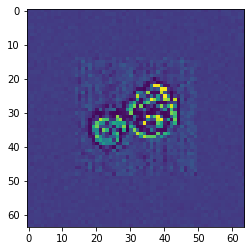

In [25]:
plt.imshow(train_dataset[25][1][0,:,:])

In [26]:

lr_scheduler = LRScheduler(policy='ReduceLROnPlateau', factor=0.1, patience=10)

# checkpoint = Checkpoint(f_params='Autoencoder_multichannel.pth', monitor='train_loss_best')

 
# early_stopping = EarlyStopping(monitor='train_loss', 
#                                patience=100, 
#                                threshold=0.0001, 
#                                threshold_mode='rel', 
#                                lower_is_better=True)

model = NeuralNetClassifier(    
    autoencoder, 
    criterion=nn.MSELoss,
    lr=0.001,
    batch_size=1024,
    max_epochs=200,
    optimizer=optim.Adam,
    iterator_train__shuffle=True,
    iterator_train__num_workers=6,
    callbacks=[lr_scheduler],
    train_split=None,
    device="cuda",
    warm_start=True)

In [27]:
model = model.fit(train_dataset, y = None)

  epoch    train_loss      dur
-------  ------------  -------
      1        0.0588  52.2145
      2        0.0290  51.9950
      3        0.0263  52.0793
      4        0.0258  52.6836
      5        0.0254  51.9296
      6        0.0219  51.8035
      7        0.0179  52.4876
      8        0.0169  51.7972
      9        0.0153  51.8013
     10        0.0141  52.5031
     11        0.0124  52.6479
     12        0.0115  52.1865
     13        0.0101  52.4796
     14        0.0097  52.5928
     15        0.0099  52.1286
     16        0.0084  51.9725
     17        0.0075  52.1353
     18        0.0069  51.9092
     19        0.0067  52.2774
     20        0.0065  52.1940
     21        0.0064  52.9148
     22        0.0062  51.9606
     23        0.0061  52.1752
     24        0.0061  51.9826
     25        0.0058  52.4699
     26        0.0058  51.9973
     27        0.0056  52.0986
     28        0.0055  51.8175
     29        0.0054  51.9940
     30        0.0054  52.3501
     31 

In [28]:
image = train_dataset[1000][0]




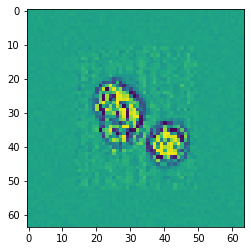

In [29]:
plt.imshow(image[0,:,:])

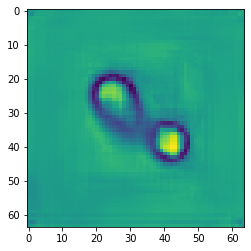

In [30]:
plt.imshow(model.module.forward(torch.unsqueeze(image.cuda() , dim = 0) ).detach().cpu()[0,0,:,:])

In [31]:
metadata.loc[train_index.tolist()+validation_index.tolist(),:]

,file,experiment,donor,condition,object_number,set,label
25,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,4147,train,B_cell
38,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,57117,train,B_T_cell_in_one_layer
107,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,30947,train,Multiplets
151,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,38634,train,B_cell
177,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,16268,train,B_cell
...,...,...,...,...,...,...,...
423746,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_4,Donor_9,-SEA,11937,validation,T_cell
423951,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_4,Donor_9,-SEA,22506,validation,T_cell_with_signaling
424277,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_4,Donor_9,-SEA,61307,validation,B_T_cell_in_one_layer
424385,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_4,Donor_9,-SEA,20652,validation,T_cell_with_signaling


In [32]:
train_transform = transforms.Compose([ 
        MinMaxScaler(           min_in =  stats["lower_bound"] , 
                                max_in =  stats["upper_bound"] , 
                                min_out =  0. , 
                                max_out =  1.),
        transforms.Resize(64)
])


test_transforms =  transforms.Compose([ 
        MinMaxScaler(           min_in =  stats["lower_bound"] , 
                                max_in =  stats["upper_bound"] , 
                                min_out =  0. , 
                                max_out =  1.),
        transforms.Resize(64)
])


In [33]:
train_dataset = DatasetGenerator(metadata.loc[train_index.tolist()+validation_index.tolist(),:], 
                                 reshape_size=reshape_size, 
                                label_map=label_map, 
                                 scaling_factor = 1.,
                                 transform = test_transforms, 
                                selected_channels=selected_channels)

test_dataset = DatasetGenerator(metadata.loc[test_index.tolist(),:],
                                 reshape_size=reshape_size, 
                                label_map=label_map,
                                 scaling_factor = 1.,
                                transform=test_transforms, 
                                selected_channels=selected_channels)

In [34]:
X_train = []
y_train = []

for i in tqdm(range(len(train_dataset))):
    X_train.append( model.module.feature_extraction(torch.unsqueeze(train_dataset[i][0].cuda() , dim = 0) ).detach().cpu().flatten().numpy()  )
    y_train.append(train_dataset[i][1].detach().cpu().numpy()  )

100%|██████████| 3654/3654 [00:48<00:00, 76.01it/s]


In [35]:
X_test = []
y_test = []

for i in tqdm(range(len(test_dataset))):
    try:
        X_test.append( model.module.feature_extraction(torch.unsqueeze(test_dataset[i][0].cuda() , dim = 0) ).detach().cpu().flatten().numpy() )
        y_test.append(test_dataset[i][1].detach().cpu()  )
    except RuntimeError:
        print(i).numpy()

100%|██████████| 1567/1567 [00:34<00:00, 45.82it/s]


In [36]:
np.array(X_train).shape

(3654, 256)

In [37]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from xgboost import XGBClassifier

lr = Pipeline([
                 ('StandardScaler', StandardScaler()), 
                 ('LogisticRegression', LogisticRegression() )
], verbose=True)

lr.fit(X_train ,y_train)



[Pipeline] .... (step 1 of 2) Processing StandardScaler, total=   0.0s
[Pipeline]  (step 2 of 2) Processing LogisticRegression, total=   0.5s


/pstore/home/shetabs1/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('StandardScaler', StandardScaler()),
                ('LogisticRegression', LogisticRegression())],
         verbose=True)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       445
           1       0.83      0.88      0.85       465
           2       0.80      0.77      0.79       347
           3       0.90      0.90      0.90       438
           4       0.88      0.84      0.86       372
           5       0.68      0.64      0.66       346
           6       0.76      0.77      0.76       465
           7       0.89      0.92      0.90       419
           8       0.93      0.92      0.93       357

    accuracy                           0.85      3654
   macro avg       0.85      0.85      0.85      3654
weighted avg       0.85      0.85      0.85      3654

------------------------------------------------------------
matthews correlation coeff: 0.8353
Cohen Kappa score: 0.8352
Accuracy: 0.8539 & balanced Accuracy: 0.8486
macro F1 score: 0.8493 & micro F1 score: 0.8539
macro Precision score: 0.8505 & micro Precision score: 0.8539
macro Recall score

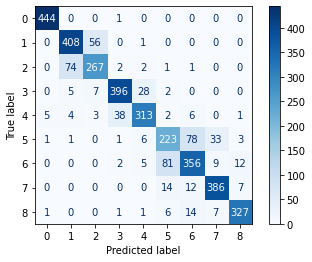

------------------------------------------------------------


In [38]:
y_pred = lr.predict(np.array(X_train) )

classification_complete_report(y_train, y_pred )

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       190
           1       0.78      0.84      0.81       200
           2       0.73      0.66      0.69       148
           3       0.84      0.84      0.84       189
           4       0.76      0.81      0.79       161
           5       0.55      0.54      0.55       147
           6       0.71      0.71      0.71       196
           7       0.89      0.84      0.86       182
           8       0.90      0.86      0.88       154

    accuracy                           0.80      1567
   macro avg       0.79      0.79      0.79      1567
weighted avg       0.80      0.80      0.79      1567

------------------------------------------------------------
matthews correlation coeff: 0.7692
Cohen Kappa score: 0.7691
Accuracy: 0.7951 & balanced Accuracy: 0.7873
macro F1 score: 0.7881 & micro F1 score: 0.7951
macro Precision score: 0.7903 & micro Precision score: 0.7951
macro Recall score

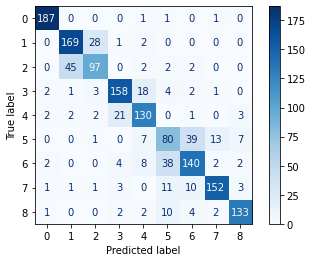

------------------------------------------------------------


In [39]:
y_pred = lr.predict(np.array(X_test) )

classification_complete_report(y_test, y_pred )

In [44]:
preds = pd.Series(y_pred).to_csv("ae_preds.csv")